# COMP90086 Workshop 8

To perform 3D reconstruction, we need to obtain a depth map. Although there are several ways to obtain a depth map, in this workshop we will only discuss the common RGB cameras. In this case, we need to perform a 3D reconstruction. The key to 3D reconstruction is 3D matching, which is the topic we will discuss today.

In this workshop, you will have some practice on the implementation steps of 3D matching.

Table of Contents

- Implement steps for 3D matching
    - Camera Calibration
    - Epipolar Geometry
    - Depth Map
    

- Extra bonus
    - Pose Estimation
    
    
- Exercises

Each section of this content covers the basic techniques that need to be mastered in order to perform 3D matching. This material has been adapted from the [OpenCV documentation](https://docs.opencv.org/4.5.2/d9/db7/tutorial_py_table_of_contents_calib3d.html).

In [1]:
## For colab user, run

#! pip install opencv-contrib-python==4.5.2.52

## After the update, You must restart the runtime in order to use newly installed versions.

### Youtube Reference
- https://www.youtube.com/@firstprinciplesofcomputerv3258
- Topics include: image formation, epipolar geomtry, depth from X, pinhole geomtry, depth of field, lense, fundamental matrix, camera calibration etc.

In [1]:
import os
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt

## 1 Camera Calibration

3D matching requires that both images have exactly the same features, in other words, there should be no distortion in either image. However, the reality is that most lenses will distort the photos you take. Therefore we need to correct it. 

The following diagram shows two common types of radial distortion: barrel distortion and pincushion distortion (Image courtesy: [OpenCV documentation](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)). 

<img style="float: ;" src="https://docs.opencv.org/2.4/_images/distortion_examples.png" width=600>

To perform the correction, we need to know the internal parameters of the camera we are using. But in most cases these parameters are unknown.

Luckily for you! OpenCV has an algorithm designed for this purpose. The process of calibrating your camera in OpenCV involves taking multiple pictures with the same checkerboard pattern from different angles using your camera (usually at least 10 photos). In this workshop, we will use some examples of chessboard images that come with OpenCV.

Once we find these parameters, we can use OpenCV to undistort the images. Come on, let's take the first step towards 3D matching.

### Extra bonus: Calibrate for our cameras!

- 1. [Get a chessboard pattern](https://docs.opencv.org/2.4/_downloads/pattern.png)
- 2. Put the printed chessboard pattern on something flat.
<img style="float: ;" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/pattern2.JPG" width=600>

- 3. Take at least 10 photos of the chessboard pattern with different variation.
<img style="float: ;" src="https://miro.medium.com/max/960/1*iA71naaNHedLcSUPMN1Zrw.jpeg" width=600>
(Image courtesy: Utkarsh Sinah from AI shack)
- 4. Coding ↓

### (i) Set up

More information on the functions used below, see:
- [cv2.findChessboardCorners](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a)
- [cv2.cornerSubPix](https://docs.opencv.org/4.5.2/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e)
- [cv2.drawChessboardCorners](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022)

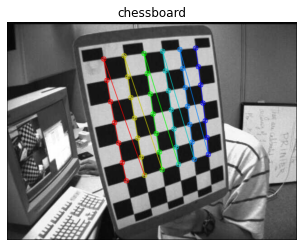

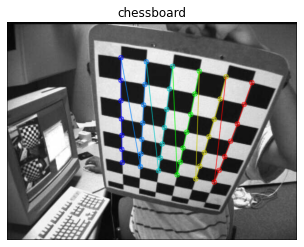

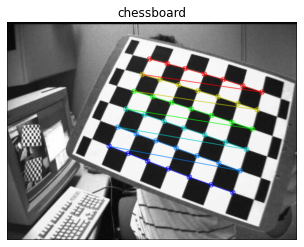

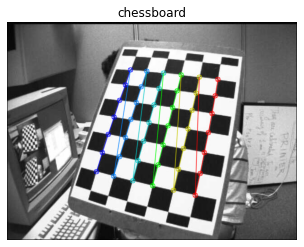

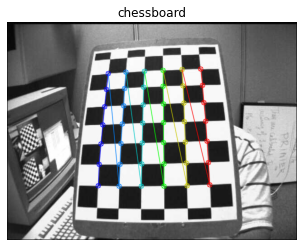

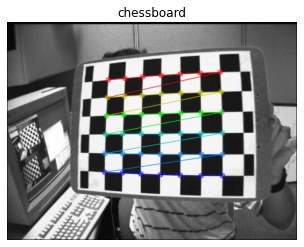

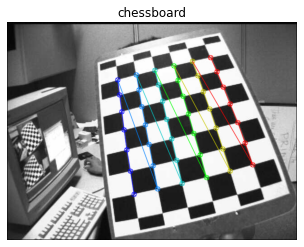

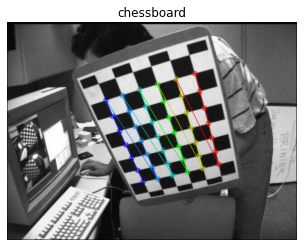

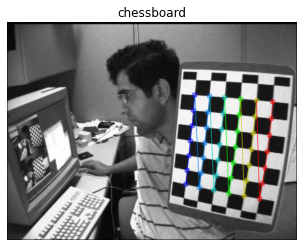

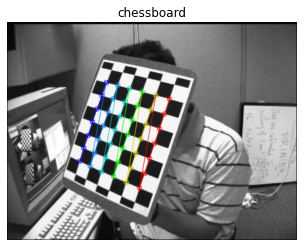

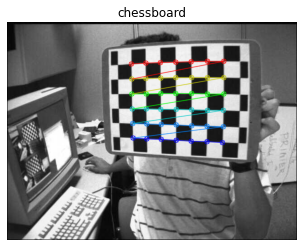

In [2]:
# Define the grid we are trying to find, 
# In this case we use 7x6 grid (see the plot show).
grid_size = (7,6)

# Arrays to store object points and image points
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.

# Prepare a grid that allows all object points to be stored orderly, 
# like (0,0,0), (1,0,0),....,(6,5,0)
objp = np.zeros((np.prod(grid_size),3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Set the termination criteria for the corner sub-pixel algorithm
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Here, we care about both accuracy and number of iterations,
# stop the algorithm iteration if specified accuracy (0.001),
# stop the algorithm after the specified number of iterations (30).

img_paths = glob.glob('./chessboard/*')

# Deal with multiple images iteratively using glob
for name in img_paths:
    img = cv2.imread(name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, grid_size, None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
        
        # Refine corner location based on criteria
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        
        # Draw and display the grid on the image
        cv2.drawChessboardCorners(img, grid_size, corners2, ret)
        
        plt.imshow(img, cmap='gray')  
        plt.title(name.split('/')[1])
        plt.axis('off')
        plt.show() 

### (ii) Calibration

More information on the functions used below, see:
- [cv2.calibrateCamera](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga687a1ab946686f0d85ae0363b5af1d7b)

The calibrateCamera() function returns the intrinsic parameters for this camera (distortion coefficients, focal length, optical center). The camera's focal length $(f_x,f_y)$ and optical centre $(c_x,c_y)$ are expressed in the camera matrix:

$$camera matrix = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$

The calibrateCamera() function also returns the extrinsic parameters for the video sequence (rotation and translation of the camera). Note that for calculations we assume that the chessboard location is fixed and the camera is moving.

In [3]:
# ret: a flag
# mtx: camera matrix 
# dist: distortion coefficients
# rvecs: rotation vectors
# tvecs: translation vectors

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

# print the camera matrix
print(mtx)

[[534.07088319   0.         341.5340768 ]
 [  0.         534.11914505 232.94565269]
 [  0.           0.           1.        ]]


In [4]:
# Save the results
np.savez('./calib.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

# Load camera parameters
#mtx = np.load('./calib.npz') ['mtx']
#dist = np.load('./calib.npz') ['dist']

### (iii) Undistortion

After undistorted the image, we can see in the result that all the edges are straight.

More information on the functions used below, see:
- [cv2.getOptimalNewCameraMatrix](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga7a6c4e032c97f03ba747966e6ad862b1)

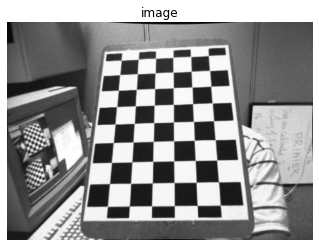

In [5]:
# Load one of the test images
rootpath='./'
img = cv2.imread(os.path.join(rootpath, "chessboard/left12.jpeg")) # Try more images!
h, w = img.shape[:2]

# Get new camera matrix and undistort image
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# Crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]

# Display the result
plt.imshow(dst, cmap='gray')  
plt.title('image')
plt.axis('off')
plt.show() 

### Exercise 1

Camera calibration requires multiple images to disambiguate between intrinsic and extrinsic factors that affect the appearance of the checkerboard in a single image. What happens if you try to calibrate with just one image? (Try a few different images.) Test your calibration by undistorting a test image, and compare the newcameramtx values to the values you obtained from calibrating with the full image set.

The result varies depending on which image you use, but the calibration (and the undistortion result) generally will not be correct. It may fail to compensate for the radial distortion of the lens, or it may assume a wrong focal length so the "undistorted" image will look stretched.

## 2 Epipolar Geometry

<center>Epipolar lines/Epiline</center>
<img style="float: ;" src="https://miro.medium.com/max/1212/1*AtZfO8s0FJGesob9n4ZDLg.png" width=450>
<center>(Image courtesy: Omar Padierna)</center>

The following diagram illustrates some basic concepts for capturing the same scene with two cameras (Image courtesy: [Epipolar geometry - Wikipedia](https://en.wikipedia.org/wiki/Epipolar_geometry)). 

<img style="float: ;" src="https://upload.wikimedia.org/wikipedia/commons/1/14/Epipolar_geometry.svg" width=450>

For more information on the concept of [epipolar geometry](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT10/node3.html), see the explanation provided by CVonline.

### (i) Find the Fundamental Matrix

To find the fundamental matrix, we need to have some matches points between two images.

Load the left and right images in grayscale

### Notes:
- Optical Centre
- Virtual Image plane
- 2D projection
- X
- X_1, X_2
- Epipoles / Epipolar points
- Epipolar line
- Alt viz, epipolar plane

#### Epipolar Constraint
- If relative position of two cameras is known
    - each point observed in one image the same point must be observed in the other image on a known epipolar line. This provides an epipolar constraint: the projection of X on the right camera plane xR must be contained in the eR–xR epipolar line.
    - This is how we do correspondence, testing if two points in our images correspond to the same X (real point in 3D)
    - Triangulation: if x_l and x_r known, we know projection lines, X is the intersection 

******** K --> F --> E

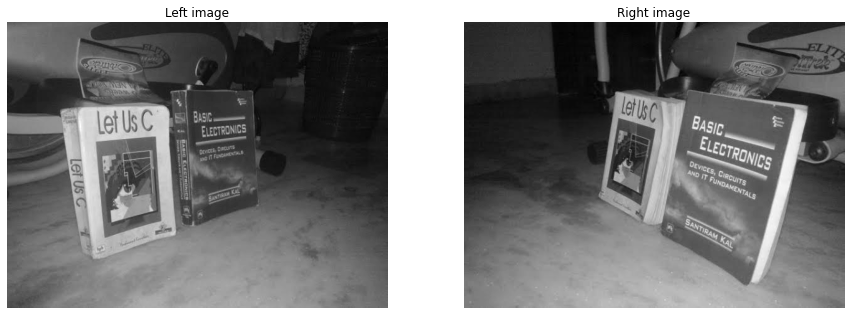

In [6]:
# Read in images from a filepath as graycsale.
imgL = cv2.imread(os.path.join(rootpath, "left.jpeg"),cv2.IMREAD_GRAYSCALE) # left image
imgR = cv2.imread(os.path.join(rootpath, "right.jpeg"),cv2.IMREAD_GRAYSCALE) # right image

# Display the images
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.show() 

### Exercise 2

Use SIFT descriptors with FLANN based matchers and ratio tests to find matches points between two images for computing the fundamental matrix.

In [7]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
ptsL = []
ptsR = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8 *n.distance: # was 0.7
        ptsL.append(kp1[m.queryIdx].pt)
        ptsR.append(kp2[m.trainIdx].pt)

ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)

Find the fundamental matrix based on the best matches.

More information on the functions used below, see:
- [cv2.findFundamentalMat](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#gae850fad056e407befb9e2db04dd9e509)

In [8]:
F, mask = cv2.findFundamentalMat(ptsL,ptsR,cv2.FM_LMEDS)

# Select only inlier points
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# print the fundamental matrix
print(F)

[[ 9.31702715e-07  3.34067367e-05 -2.67771143e-03]
 [ 1.22663351e-05  3.78485992e-06 -1.74599768e-02]
 [-7.78298559e-04  2.40236663e-03  1.00000000e+00]]


Find the epilines (epipolar lines) in both the images and draw these lines on the images.
Epilines correspond to points in the opposing image.

More information on the functions used below, see:
- Drawing Functions: &ensp;[cv2.line](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2)&ensp;&ensp;[cv2.circle](https://docs.opencv.org/4.5.2/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)
-[cv2.computeCorrespondEpilines](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga19e3401c94c44b47c229be6e51d158b7)

In [9]:
# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2

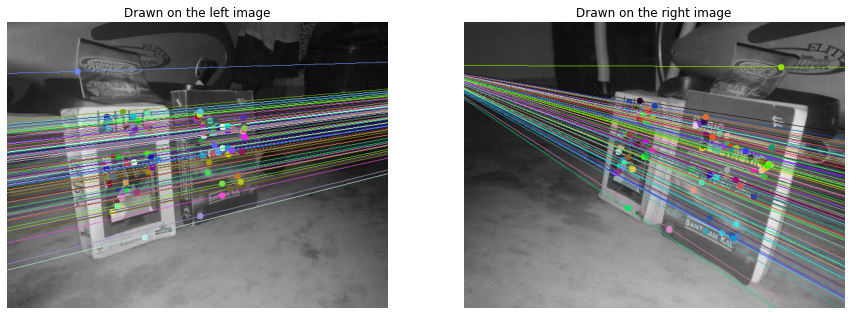

In [10]:
# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

## What does it mean that the epipole is outside of the view?

The results display two images with epilines which correspond to points from the opposing image. You may notice that the meeting point (i.e. epipole) of all epilines occurs outside of the view. 

## 3 Stereo Depth Map

We intend to compute the depth of objects detected in a group of stereo images. To do so, we need to generate a greyscale heat map, where lighter greys represent objects close to the lens, and darker greys mean objects further away.

OpenCV provides built-in functions for generating a depth map of a set of stereo images. The following code demonstrates this process.

Note: 
- To use this function with your own captured images, you should always perform a camera calibration first and then undistort your images. Camera calibration only needs to be performed once, unless you change cameras. Nevertheless, you should always undistort your images each time you take some new ones.

- It is important to make both cameras at the same height (as our eyes). Check out [this blog](https://erget.wordpress.com/2014/02/01/calibrating-a-stereo-camera-with-opencv/) on how to make your own dual camera system for better results. If you are going to use your phone camera to capture images, please move the camera horizontally very carefully to ensure there is no vertical movement (try using a tripod for example). 

More information on the functions used below, see:
 - [cv2.StereoBM_create](https://docs.opencv.org/4.5.2/d9/dba/classcv_1_1StereoBM.html)

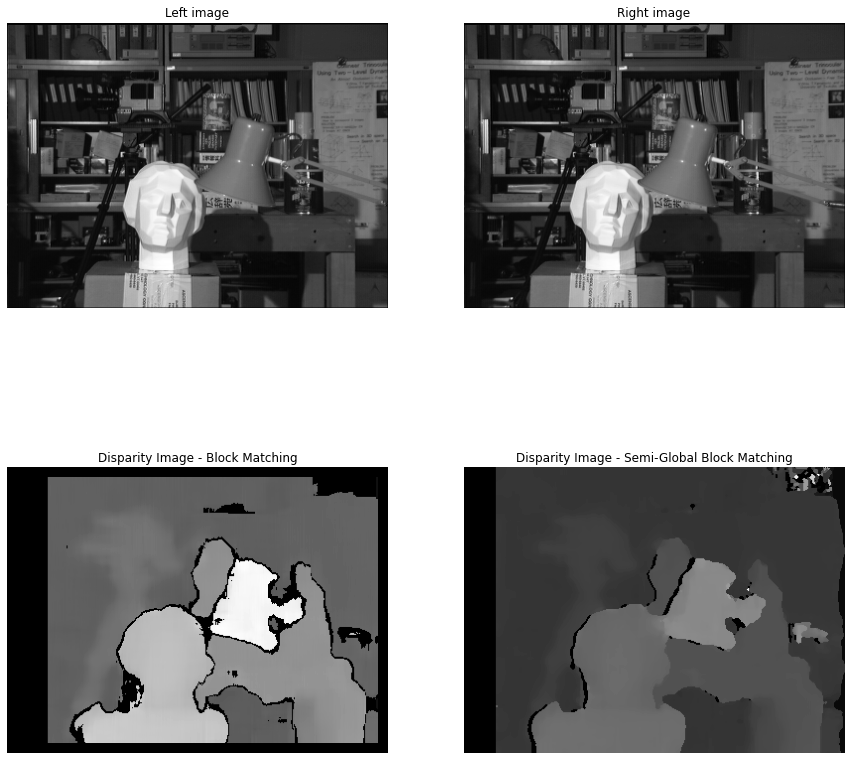

In [11]:
# Read in images from a filepath as graycsale
imgL= cv2.imread(os.path.join(rootpath, "tsukuba_l.png"),cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(os.path.join(rootpath, "tsukuba_r.png"),cv2.IMREAD_GRAYSCALE)

# Computing stereo correspondence using the block matching algorithm.
# Initialize the stereo block matching object 
''' numDisparities - the disparity search range. For each pixel algorithm will find 
                     the best disparity from 0 (default minimum disparity) to numDisparities. 
                     The search range can then be shifted by changing the minimum disparity.
    blockSize - the linear size of the blocks compared by the algorithm. 
                The size should be odd (as the block is centered at the current pixel). 
                Larger block size implies smoother, though less accurate disparity map. 
                Smaller block size gives more detailed disparity map, 
                but there is higher chance for algorithm to find a wrong correspondence. '''
num_disp = 32 # try to tune the parameters to get better&smooth result
block_size = 21
stereoBM = cv2.StereoBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparityBM = stereoBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
min = disparityBM.min()
max = disparityBM.max()
disparityBM = ((disparityBM - min) / (max - min)*255).astype(np.uint8)

# Computing stereo correspondence using the semi-global block matching algorithm.
# This method uses block matching with additional constraints (disparity smoothness)
# Initialize the stereo block matching object 
stereoSGBM = cv2.StereoSGBM_create(numDisparities=num_disp,
                             blockSize=block_size)

# Compute the disparity image
disparitySGBM = stereoSGBM.compute(imgL,imgR)

# Scale the pixel values to between 0-255 (Or you can normalized to [0,1])
min = disparitySGBM.min()
max = disparitySGBM.max()
disparitySGBM = ((disparitySGBM - min) / (max - min)*255).astype(np.uint8)

# Display the result
plt.subplots(figsize=(15, 15)) 

plt.subplot(2,2,1)
plt.imshow(imgL, cmap='gray')  
plt.title('Left image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(imgR, cmap='gray')  
plt.title('Right image')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(disparityBM,'gray')
plt.title('Disparity Image - Block Matching')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(disparitySGBM,'gray')
plt.title('Disparity Image - Semi-Global Block Matching')
plt.axis('off')

plt.show()

### Exercise 3

What is the effect of changing numDisparities and blockSize? How do the block matching and semi-global block matching results differ?

### Exercise 4
Use the cv2.StereoSGBM_create function (the semi-global block matching algorithm) for generating a depth map of a set of stereo images.

Note: SGBM works with either grayscale or color images. BM only works with grayscale.

More information on the functions and parameters used below, see:
 - [cv2.StereoSGBM_create](https://docs.opencv.org/4.5.2/d2/d85/classcv_1_1StereoSGBM.html)

In [ ]:
# Read in images from a filepath and downscale images for faster processing
imgL= cv2.pyrDown(cv2.imread(os.path.join(rootpath, 'aloeL.jpeg'))) 
imgR = cv2.pyrDown(cv2.imread(os.path.join(rootpath, 'aloeR.jpeg')))

# Set disparity parameters
# your code

stereo = cv2.StereoSGBM_create(
    # your code
    )

# Compute the disparity image
disp = stereo.compute(imgL,imgR)

# Scale the pixel values to between 0-255 for a grayscale image
# your code

# Convert the colour from BGR to RGB for display
color_imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
color_imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# Display the result
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(color_imgL)  
plt.title('Left image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(color_imgR)  
plt.title('Right image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(disp,'gray')
plt.title('Disparity Image')
plt.axis('off')

plt.show()

### Exercise 5

Consider the images shown below. Describe two cues that can be used to infer depth from each image and explain what can be computed from each cue.

<img style="float: ;" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/room.jpg" width=400>

    Your Answer

<img style="float: ;" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/lake.jpg" width=400>

    Your Answer

### Exercise 6

(1) What is an epipolar line? Give a geometric explanation for why the intersection of epipolar lines in one image corresponds to the location of the optical centre of the other image's camera. Do not include formulas or computation in your answer.

    Your Answer

(2) Suppose you have a pair of images of the same scene, taken from two calibrated cameras 10 m apart. The translation direction and rotation between the two cameras is unknown. If you can match a number of points between the two images, is it possible to compute the distance to these points? Briefly explain how you would compute the distances to points, or explain why it is not possible to compute this. If your answer would depend on additional constraints, note these in your explanation.

    Your Answer

# Extra Bonus: 3D effects

This is an extra bonus for you to create some cool 3D effects on 2D images, using the basic principles behind Augmented Reality algorithms.

We have learned how to find the camera matrix, distortion coefficients, etc. Now we can utilize the parameters obtained from the camera calibration section to estimate the positions of objects in the real-world space (in this case, the checkerboard). Once we know the position of an object in space, we can draw some 2D diagrams in the image to simulate a 3D object in the real world. In the example below, we will draw some simple shapes (a 3D coordinate axes or a 3D cube) in such a way that they appear to be attached to the chessboard.

In [ ]:
# Define a function to draws 3D coordinate axes (X, Y, Z axes) on the first corner of chessboard
def draw_axes(img, corners, imgPoints):
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgPoints[0].ravel()), (255, 0, 0), 5)
    img = cv2.line(img, corner, tuple(imgPoints[1].ravel()), (0, 255, 0), 5)
    img = cv2.line(img, corner, tuple(imgPoints[2].ravel()), (0, 0, 255), 5)
    return img

In [ ]:
# Define a function to draws 3D cube on the first corner of chessboard
def draw_cube(img, corners, imgpts):
    imgpts = np.int32(imgpts).reshape(-1,2)
    # draw ground floor in green
    img = cv2.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    # draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv2.line(img, tuple(imgpts[i]), tuple(imgpts[j]),(255),3)
    # draw top layer in red color
    img = cv2.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    return img

In [ ]:
# Load the previously saved camera calibration parameters
with np.load('./calib.npz') as calibPara:
    mtx, dist, rvecs, tvecs = [calibPara[i] for i in ('mtx', 'dist', 'rvecs', 'tvecs')]

In [ ]:
# This function draws 3D coordinate axes(AXIX or 0) or 3D cube (CUBE or 1) based on the input 
AXIX=0
CUBE=1
def draw_3d(method):
    # Define the rows&cols we are trying to find
    rows = 7
    cols = 6

    # Set the termination criteria for the corner sub-pixel algorithm
    criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 0.001)

    # Prepare a grid that allows all object points to be stored orderly
    objectPoints = np.zeros((rows * cols, 1, 3), np.float32)
    objectPoints[:, :, :2] = np.mgrid[0:rows, 0:cols].T.reshape(-1, 1, 2)

    # Create the axis points for draw_axis function.
    ''' Draw axis of length 3.
        X axis is drawn from (0,0,0) to (3,0,0), 
        Y axis is drawn from (0,0,0) to (0,3,0),
        Z axis is drawn from (0,0,0) to (0,0,-3). 
        Negative denotes it is drawn towards the camera.
    '''
    axisPoints_axis = np.float32([[3, 0, 0], [0, 3, 0], [0, 0, -3]]).reshape(-1, 3) 

    # Create the axis points for draw_cube function
    axisPoints_cube =  np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0],
                                   [0,0,-3],[0,3,-3],[3,3,-3],[3,0,-3]]) #the 8 corners of a cube in 3D space

    # Loop over the image files
    for name in glob.glob('./chessboard/*'):
        # Load the image and convert it to gray scale
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # Make sure the chess board pattern was found in the image
        if ret:
            # Refine corner location based on criteria
            corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Find the rotation and translation vectors
            val, rvecs, tvecs, inliers = cv2.solvePnPRansac(objectPoints, corners, mtx, dist)

            if method==AXIX:
                # Project the 3D axis points to the image plane
                axisImgPoints, jac = cv2.projectPoints(axisPoints_axis, rvecs, tvecs, mtx, dist)
            
                # Draw 3D coordinate axes
                img = draw_axes(img, np.int32(corners), np.int32(axisImgPoints))
            
            elif method==CUBE:
                # Project the 3D axis points to the image plane
                axisImgPoints, jac = cv2.projectPoints(axisPoints_cube, rvecs, tvecs, mtx, dist)
                
                # Draw cube
                img = draw_cube(img, np.int32(corners), np.int32(axisImgPoints))

        # Display the results
        plt.imshow(img, cmap='gray')  
        plt.title(name.split('/')[1])
        plt.axis('off')
        plt.show() 

In [ ]:
draw_3d(AXIX)

In [ ]:
draw_3d(CUBE)